https://keras.io/guides/transfer_learning/

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  8 21:38:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os


In [4]:
IMAGE_SIZE = [224, 224]   # era 150 224
threshold = 0.5

In [5]:
from google.colab import drive
#drive.mount('/content/drive')
workdir_path = '/content/drive/MyDrive/16-Mestrado/22.2/DeepLearning-Karla/trabalho/inception'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
workdir_path = '/content/drive/MyDrive/22.2/DeepLearning-Karla/Trabalho/conferir/inception'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)

os.chdir(workdir_path)




In [6]:
!pwd
os.listdir()

/content/drive/MyDrive/22.2/DeepLearning-Karla/Trabalho/conferir/inception


['sem',
 'modelos',
 'com',
 '50epoc_model-2022.11.13-posbarbara',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'photo.jpg',
 'out',
 'retiradas-do-com',
 'hanseniase_VGG16-2022.12.10.h5',
 'hanseniase_VGG16-2022.12.10-final.h5',
 'LossVal_loss.png',
 'AccVal_acc.png',
 'model-25epc-2022.12.09.json',
 'modelFT-25epc-2022.12.10.h5',
 'modelFT-5epc-2022.12.10.h5']

In [7]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], include_top=False) #weights='imagenet'

In [8]:
# congelando as camadas 
for layer in vgg.layers:
  layer.trainable = False

In [9]:
# criando o head de classificacao
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)                  
prediction = Dense(1, activation='sigmoid')(x)   # uma unica saida e nao duas como antes


In [10]:
# create a model object = vgg + head
model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.0005), 
              loss = 'binary_crossentropy',    ## troquei
              metrics = ['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Acessando algumas imagens

In [13]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

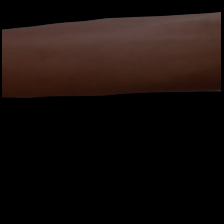

In [14]:
imagem=load_img('sem/Untitled71_20221024184551.png', target_size=(224,224,3));   # era 224
imagem 

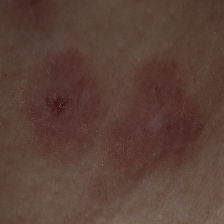

In [15]:
imagem=load_img('com/face-closeup-SIM/Image-097DA4-face-closeup.jpg', target_size=(224,224,3));   # era 224
imagem

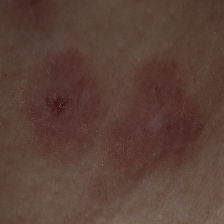

In [16]:
imagem=load_img('com/face-closeup-SIM/Image-097DA4-face-closeup.jpg', target_size=(224,224,3));   # era 224
imagem

In [17]:
# listando as imagens com hanseniase,
# que estao em diretorios que comecam com  "COM"
arquivos_com = []
os.chdir(workdir_path)
os.chdir('com')
for pasta in os.listdir():
  #print(f'diretorio {pasta}')
  if pasta.endswith('-SIM'):
    os.chdir(pasta)
    for arquivo in os.listdir():
      arquivos_com.append("com" + "/" + pasta+ "/" + arquivo)
    os.chdir('../')
print(arquivos_com)

['com/face-closeup-SIM/Image-097DA4-face-closeup.jpg', 'com/face-closeup-SIM/Image-228FM1-face-closeup.jpg', 'com/face-closeup-SIM/Image-228FM2-face-closeup.jpg', 'com/face-closeup-SIM/Image-222IS1-face-closeup.jpg', 'com/face-closeup-SIM/Image-191JE1-face-closeup.jpg', 'com/face-closeup-SIM/Image-082RM2-face-closeup.jpg', 'com/face-closeup-SIM/Image-129RP5-face-closeup.jpg', 'com/face-closeup-SIM/Image-130GD1-face-closeup.jpg', 'com/face-closeup-SIM/Image-131JO1-face-closeup.jpg', 'com/face-closeup-SIM/Image-131JO2-face-closeup.jpg', 'com/face-closeup-SIM/Image-131JO3-face-closeup.jpg', 'com/face-closeup-SIM/Image-131JO4-face-closeup.jpg', 'com/face-closeup-SIM/Image-135RC2-face-closeup.jpg', 'com/face-closeup-SIM/Image-140AB3-face-closeup.jpg', 'com/face-closeup-SIM/Image-145MR1-face-closeup.jpg', 'com/face-closeup-SIM/Image-156AS1-face-closeup.jpg', 'com/face-closeup-SIM/Image-164JF1-face-closeup.jpg', 'com/face-edge-SIM/Image-101NP2-face-edge.jpg', 'com/face-edge-SIM/Image-129RP5-f

In [18]:
len(arquivos_com)

141

In [19]:
# listando as imagens SEM hanseniase,
# que estao em diretorios que comecam com  "SEM"
arquivos_sem = []
os.chdir(workdir_path)
os.chdir('sem')
for arquivo in os.listdir():
    arquivos_sem.append( 'sem' + "/" + arquivo)
os.chdir('../')
print(arquivos_sem)

['sem/IMG_6889.PNG', 'sem/Untitled71_20221024184551.png', 'sem/Untitled71_20221024184805.png', 'sem/Untitled71_20221024184625.png', 'sem/Untitled71_20221024184611.png', 'sem/Untitled71_20221024184713.png', 'sem/Untitled71_20221024184821.png', 'sem/Untitled71_20221024184451.png', 'sem/Untitled71_20221024184420.png', 'sem/20221105_125119.jpg', 'sem/20221105_125215.jpg', 'sem/20221105_125218.jpg', 'sem/20221105_125225.jpg', 'sem/20221105_125347.jpg', 'sem/20221105_125359.jpg', 'sem/20221105_140545.jpg', 'sem/20221105_140601.jpg', 'sem/20221105_140623.jpg', 'sem/20221105_140630.jpg', 'sem/20221105_150754.jpg', 'sem/20221105_150814.jpg', 'sem/20221105_150924.jpg', 'sem/20221110_211338.jpg', 'sem/20221110_211350.jpg', 'sem/20221110_211515.jpg', 'sem/20221110_211523.jpg', 'sem/20221110_211614.jpg', 'sem/20221110_211623.jpg', 'sem/internet003.jpg', 'sem/internet004.jpg', 'sem/internet005.jpg', 'sem/internet007.jpg', 'sem/internet008.jpg', 'sem/internet009.jpg', 'sem/internet014.jpg', 'sem/inte

In [20]:
len(arquivos_sem)

38

In [21]:
##y_col: if class_mode is "binary" or "sparse" it must include the given y_col column with class values as strings.
## x_col: 	string, column in dataframe that contains the filenames (or absolute paths if directory is None). 
df = pd.DataFrame()
df_sem = pd.DataFrame(arquivos_sem,columns =['filename'])
df_sem['class'] = 'sem'
df_com = pd.DataFrame(arquivos_com,columns =['filename'])
df_com['class'] = 'com'
df = df.append(df_com)
df = df.append(df_sem)
df.shape

<ipython-input-21-7a87479fc283>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_com)
<ipython-input-21-7a87479fc283>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_sem)


(179, 2)

In [22]:
df_train, df_test = train_test_split(df, test_size=0.1,random_state=42)
print(df_train.shape)
print(df_test.shape)

(161, 2)
(18, 2)


In [24]:
df_train, df_valid = train_test_split(df_train, test_size=0.1,random_state=42)
print(df_train.shape)
print(df_valid.shape)

(144, 2)
(17, 2)


In [25]:
df_train

,filename,class
103,com/ulimbs-closeup-SIM/Image-201CO2-ulimbs-clo...,com
105,com/ulimbs-closeup-SIM/Image-197LS1-ulimbs-clo...,com
29,com/llimbs-edge-SIM/Image-193AS1-llimbs-edge.jpg,com
81,com/trunk-edge-SIM/Image-152JS1-trunk-edge.jpg,com
17,sem/20221105_140623.jpg,sem
...,...,...
138,com/ulimbs-closeup-SIM/Image-168AS2-ulimbs-clo...,com
80,com/trunk-edge-SIM/Image-149CV1-trunk-edge.jpg,com
100,com/ulimbs-closeup-SIM/Image-217MC2-ulimbs-clo...,com
2,sem/Untitled71_20221024184805.png,sem


In [26]:
df_valid

,filename,class
35,com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg,com
34,com/llimbs-edge-SIM/Image-187SB2-llimbs-edge.jpg,com
28,sem/internet003.jpg,sem
32,com/llimbs-edge-SIM/Image-188EB2-llimbs-edge.jpg,com
62,com/trunk-edge-SIM/Image-183AP5-trunk-edge.jpg,com
0,sem/IMG_6889.PNG,sem
20,sem/20221105_150814.jpg,sem
6,com/face-closeup-SIM/Image-129RP5-face-closeup...,com
5,com/face-closeup-SIM/Image-082RM2-face-closeup...,com
1,com/face-closeup-SIM/Image-228FM1-face-closeup...,com


In [27]:
df_test

,filename,class
78,com/trunk-edge-SIM/Image-147AS1-trunk-edge.jpg,com
16,com/face-closeup-SIM/Image-164JF1-face-closeup...,com
65,com/trunk-edge-SIM/Image-205IL1-trunk-edge.jpg,com
114,com/ulimbs-closeup-SIM/Image-069PO1-ulimbs-clo...,com
76,com/trunk-edge-SIM/Image-124CG4-trunk-edge.jpg,com
19,com/face-edge-SIM/Image-145MR1-face-edge.jpg,com
122,com/ulimbs-closeup-SIM/Image-088ES3-ulimbs-clo...,com
24,com/llimbs-edge-SIM/Image-218AA1-llimbs-edge.jpg,com
66,com/trunk-edge-SIM/Image-204MB3-trunk-edge.jpg,com
11,sem/20221105_125218.jpg,sem


data augmentation

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator(rescale = 1.0/255.)   # aproveita e faz a normalizacao


train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='class',
                                                    batch_size = 10,             # era 10
                                                    class_mode = 'binary',  #'binary',   era categorical
                                                    target_size = (224, 224))     # era 224 
# VAI IMPRIMIR A QUANTIDADE DO TRAIN
validation_generator =  valid_datagen.flow_from_dataframe( df_test,
                                                          x_col='filename',
                                                          y_col='class',
                                                          batch_size  = 10,           #5,  # era 10
                                                          class_mode  = 'binary', #'binary', 
                                                          target_size = (224, 224))    # era 224
														  

Found 144 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.


# Treinando o modelo

In [29]:
from keras.callbacks import EarlyStopping

In [30]:
#callback = EarlyStopping(monitor='loss', patience=3,verbose=1)
callback = EarlyStopping(monitor = 'val_loss', patience = 5,verbose=1)

In [31]:
history = model.fit(                        ## forma semelhante ao inception
            train_generator,
            validation_data = validation_generator,
            epochs = 15,           
            verbose = 1,
            callbacks=[callback])

Epoch 1/15
15/15 [==============================] - 102s 6s/step - loss: 1.1746 - accuracy: 0.7222 - val_loss: 0.5603 - val_accuracy: 0.7778
Epoch 2/15
15/15 [==============================] - 96s 6s/step - loss: 0.7862 - accuracy: 0.7292 - val_loss: 0.4106 - val_accuracy: 0.8889
Epoch 3/15
15/15 [==============================] - 88s 6s/step - loss: 0.7713 - accuracy: 0.7569 - val_loss: 0.1815 - val_accuracy: 0.8889
Epoch 4/15
15/15 [==============================] - 87s 6s/step - loss: 0.6773 - accuracy: 0.7431 - val_loss: 0.4061 - val_accuracy: 0.8333
Epoch 5/15
15/15 [==============================] - 85s 6s/step - loss: 0.8281 - accuracy: 0.7153 - val_loss: 0.2215 - val_accuracy: 0.8889
Epoch 6/15
15/15 [==============================] - 84s 6s/step - loss: 0.8417 - accuracy: 0.7569 - val_loss: 0.2394 - val_accuracy: 0.8889
Epoch 7/15
15/15 [==============================] - 85s 6s/step - loss: 0.5336 - accuracy: 0.7986 - val_loss: 0.2078 - val_accuracy: 1.0000
Epoch 8/15
15/15 [=

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [33]:
print(acc)
print(val_acc)

[0.7222222089767456, 0.7291666865348816, 0.7569444179534912, 0.7430555820465088, 0.7152777910232544, 0.7569444179534912, 0.7986111044883728, 0.8194444179534912, 0.7986111044883728, 0.8194444179534912, 0.8541666865348816, 0.8611111044883728, 0.8472222089767456]
[0.7777777910232544, 0.8888888955116272, 0.8888888955116272, 0.8333333134651184, 0.8888888955116272, 0.8888888955116272, 1.0, 0.8888888955116272, 1.0, 0.8888888955116272, 1.0, 0.8888888955116272, 0.8888888955116272]


In [34]:
epochs = range(len(acc))

def PlotHistory(history):    
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [35]:
#score = model.evaluate_generator(validation_generator, verbose=0)
score = model.evaluate(validation_generator, verbose=1)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 10s 4s/step - loss: 0.1590 - accuracy: 0.8889

Test score: 0.15895038843154907
Test accuracy: 0.8888888955116272


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


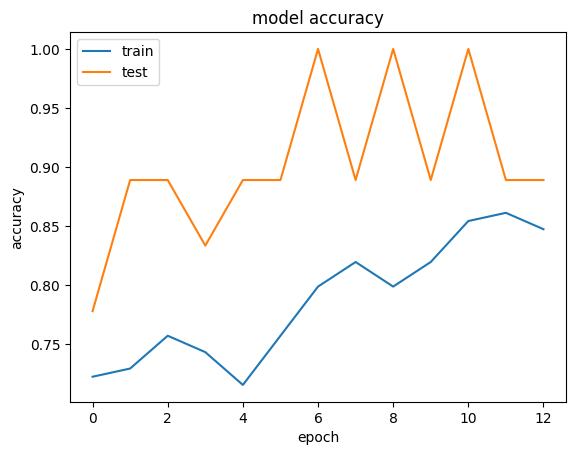

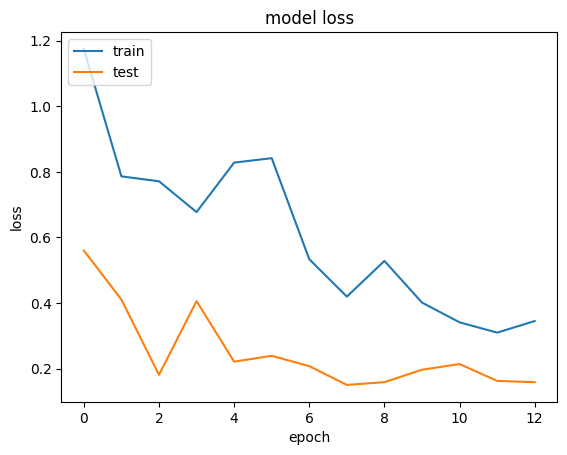

In [36]:
PlotHistory(history)

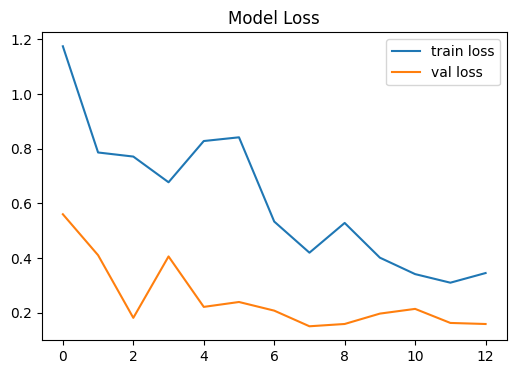

<Figure size 640x480 with 0 Axes>

In [37]:
# loss
fig = plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.show()
plt.savefig('LossVal_loss')

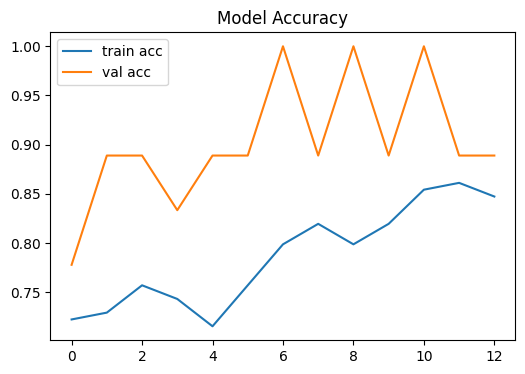

<Figure size 640x480 with 0 Axes>

In [38]:
# accuracies
fig = plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Model Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [39]:
import tensorflow as tf
from keras.models import load_model

In [40]:
# nao vou salvar sempre um modelo
model.save('hanseniase_VGG16-2023.06.08-final.h5')

In [41]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

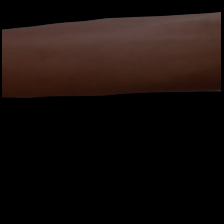

In [42]:
test_image = load_img('sem/Untitled71_20221024184551.png', target_size=(224,224,3));  # era 224
test_image

In [43]:
# acertou
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)
print(result)


1/1 [==============================] - 1s 823ms/step
[[1.]]


In [44]:
if  result > threshold :
    prediction = 'SEM'
else:
    prediction = 'COM'
print (f'{prediction} : {result}')

SEM : [[1.]]


## Olhando umas predicoes do conjunto de validacao

In [46]:
df_valid

,filename,class
35,com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg,com
34,com/llimbs-edge-SIM/Image-187SB2-llimbs-edge.jpg,com
28,sem/internet003.jpg,sem
32,com/llimbs-edge-SIM/Image-188EB2-llimbs-edge.jpg,com
62,com/trunk-edge-SIM/Image-183AP5-trunk-edge.jpg,com
0,sem/IMG_6889.PNG,sem
20,sem/20221105_150814.jpg,sem
6,com/face-closeup-SIM/Image-129RP5-face-closeup...,com
5,com/face-closeup-SIM/Image-082RM2-face-closeup...,com
1,com/face-closeup-SIM/Image-228FM1-face-closeup...,com


In [45]:
from PIL import Image

In [70]:
df_valid.filename


'com/face-closeup-SIM/Image-082RM2-face-closeup.jpg'

In [71]:
img1='com/face-closeup-SIM/Image-082RM2-face-closeup.jpg'
img1=df_valid.filename[34]  ## com
img2='sem/Untitled71_20221024184821.png'
img2=df_valid.filename[28]  ## sem

img3= df_valid.filename[5]  ## com
img4=df_valid.filename[20]   ## sem
imgs = [img1, img2, img3, img4]

In [57]:
class pred:
  def __init__(self, modelo):
    self.modelo = modelo
  def Xload_img(self,path):
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
  def predict_(self):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((224, 224), Image.ANTIALIAS)) #???? tira 20%
    plt.show()
    
    


    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    preds=[]
    for i ,img_path in enumerate(imgs):
        img = load_img(img_path, target_size= (224,224))     # era 224
        img = img_to_array(img)
        img = np.expand_dims(img,axis=0)
        pred = model.predict(img)
        if pred[0][0] < threshold :
          prediction = 'COM'
        else:
          prediction = 'SEM'
        print (f'{prediction} : {pred[0][0]}')
        preds.append(pred)
    return(preds)
  pass

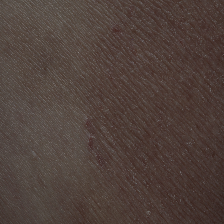

In [74]:
## ACERTOU
imagem=load_img(img1, target_size=(224,224,3));
imagem

In [75]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 39ms/step
[[0.01313438]]


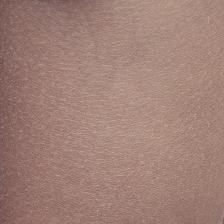

In [76]:
## errou
imagem=load_img(img2, target_size=(224,224,3));   # era 224
imagem

In [77]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 28ms/step
[[0.03956193]]


In [78]:
img3

'com/face-closeup-SIM/Image-082RM2-face-closeup.jpg'

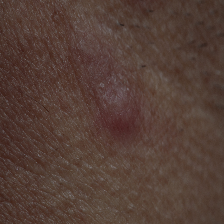

In [79]:
## ACERTOU
imagem=load_img(img3, target_size=(224,224,3));   # era 224
imagem

In [80]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 24ms/step
[[0.0322788]]


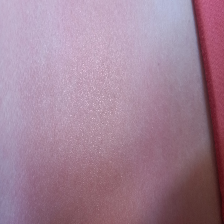

In [81]:
## ACERTOU
imagem=load_img(img4, target_size=(224,224,3));   # era 224
imagem

In [82]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 20ms/step
[[0.7723442]]


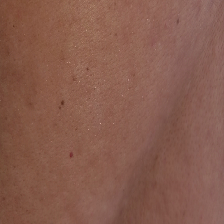

In [94]:
# ERROU
imagem=load_img(arquivos_sem[0], target_size=(224,224,3));   # era 224
imagem

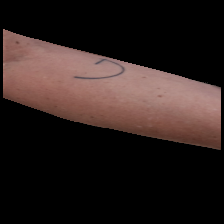

In [83]:
## ACERTOU
imagem=load_img(arquivos_sem[2], target_size=(224,224,3));   # era 224
imagem

In [84]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 23ms/step
[[0.97566426]]


# Verificando validacao

Avaliando conjunto de validacao

In [148]:
df_performance = pd.DataFrame()
df_performance = df_valid.copy()
df_performance.reset_index(drop=True, inplace=True)
df_performance.predict = ''

In [149]:
df_performance


,filename,class,score,predict
0,com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg,com,0.042634,
1,com/llimbs-edge-SIM/Image-187SB2-llimbs-edge.jpg,com,0.013134,
2,sem/internet003.jpg,sem,0.039562,
3,com/llimbs-edge-SIM/Image-188EB2-llimbs-edge.jpg,com,0.024891,
4,com/trunk-edge-SIM/Image-183AP5-trunk-edge.jpg,com,0.011159,
5,sem/IMG_6889.PNG,sem,0.184978,
6,sem/20221105_150814.jpg,sem,0.772344,
7,com/face-closeup-SIM/Image-129RP5-face-closeup...,com,0.100235,
8,com/face-closeup-SIM/Image-082RM2-face-closeup...,com,0.032279,
9,com/face-closeup-SIM/Image-228FM1-face-closeup...,com,0.005800,


In [150]:
THRESHOULD = 0.1
df_performance.score = 0.0
df_performance.predict = ''

In [152]:
for i in range(len(df_performance)):
    #print(df_performance.loc[i,'filename'])
  imagem=load_img(df_performance.loc[i,'filename'], target_size=(224,224,3));
  imagem=np.array(imagem)
  cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
  df_performance.loc[i,'score'] = float(cls)

  if (float(cls) > THRESHOULD):
    df_performance.loc[i,'predict'] = 'sem'
    print(f'sem {cls}')
  else:
    df_performance.loc[i,'predict'] = 'com'
    print(f'com {cls}')

1/1 [==============================] - 0s 21ms/step
com [[0.04263414]]
1/1 [==============================] - 0s 22ms/step
com [[0.01313438]]
1/1 [==============================] - 0s 24ms/step
com [[0.03956193]]
1/1 [==============================] - 0s 21ms/step
com [[0.02489133]]
1/1 [==============================] - 0s 24ms/step
com [[0.01115926]]
1/1 [==============================] - 0s 21ms/step
sem [[0.18497846]]
1/1 [==============================] - 0s 21ms/step
sem [[0.7723442]]
1/1 [==============================] - 0s 23ms/step
sem [[0.10023455]]
1/1 [==============================] - 0s 22ms/step
com [[0.0322788]]
1/1 [==============================] - 0s 32ms/step
com [[0.00579977]]
1/1 [==============================] - 0s 31ms/step
com [[0.01134329]]
1/1 [==============================] - 0s 43ms/step
com [[0.03934102]]
1/1 [==============================] - 0s 22ms/step
com [[0.01843216]]
1/1 [==============================] - 0s 22ms/step
com [[0.01144542]]
1/1 [===

In [153]:
df_performance['predict'].value_counts(normalize=True)
#data.stars.value_counts
#df_performance.head(50)


com    0.764706
sem    0.235294
Name: predict, dtype: float64

In [154]:
df_performance['class'].value_counts(normalize=True)

com    0.764706
sem    0.235294
Name: class, dtype: float64

Matriz de confusao

In [155]:
df_performance.head(20)

,filename,class,score,predict
0,com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg,com,0.042634,com
1,com/llimbs-edge-SIM/Image-187SB2-llimbs-edge.jpg,com,0.013134,com
2,sem/internet003.jpg,sem,0.039562,com
3,com/llimbs-edge-SIM/Image-188EB2-llimbs-edge.jpg,com,0.024891,com
4,com/trunk-edge-SIM/Image-183AP5-trunk-edge.jpg,com,0.011159,com
5,sem/IMG_6889.PNG,sem,0.184978,sem
6,sem/20221105_150814.jpg,sem,0.772344,sem
7,com/face-closeup-SIM/Image-129RP5-face-closeup...,com,0.100235,sem
8,com/face-closeup-SIM/Image-082RM2-face-closeup...,com,0.032279,com
9,com/face-closeup-SIM/Image-228FM1-face-closeup...,com,0.005800,com


In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
def predict_and_evaluate(y_test, y_pred):  

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred, average='weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred, y_test)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f")
  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['Benigno', 'Maligno']) 
  ax.yaxis.set_ticklabels(['Benigno', 'Maligno'])
  plt.show()



Acurácia:  0.8823529411764706
Kappa:  0.6730769230769231
F1:  0.8823529411764706


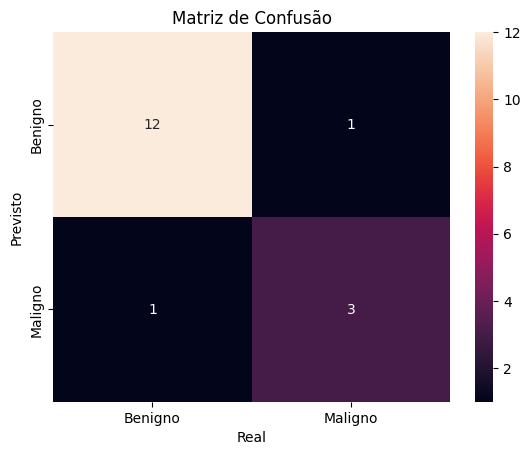

In [157]:

y_test = df_performance['class']
y_pred = df_performance['predict']
predict_and_evaluate(y_test, y_pred)

In [158]:
df_performance[0:5]

,filename,class,score,predict
0,com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg,com,0.042634,com
1,com/llimbs-edge-SIM/Image-187SB2-llimbs-edge.jpg,com,0.013134,com
2,sem/internet003.jpg,sem,0.039562,com
3,com/llimbs-edge-SIM/Image-188EB2-llimbs-edge.jpg,com,0.024891,com
4,com/trunk-edge-SIM/Image-183AP5-trunk-edge.jpg,com,0.011159,com


In [159]:
img5 = df_performance.iloc[0,0]
img5

'com/llimbs-edge-SIM/Image-071FP5-llimbs-edge.jpg'

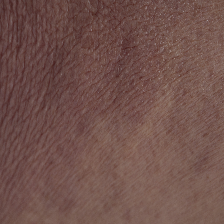

In [160]:
imagem=load_img(img5, target_size=(224,224,3));   # era 224
imagem

In [161]:
imagem=np.array(imagem)
cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 26ms/step
[[0.04263414]]


# verificando base de teste

In [162]:
df_test

,filename,class,score,predict
0,com/trunk-edge-SIM/Image-147AS1-trunk-edge.jpg,com,0.033442,sem
1,com/face-closeup-SIM/Image-164JF1-face-closeup...,com,0.029132,sem
2,com/trunk-edge-SIM/Image-205IL1-trunk-edge.jpg,com,0.037832,sem
3,com/ulimbs-closeup-SIM/Image-069PO1-ulimbs-clo...,com,0.010193,sem
4,com/trunk-edge-SIM/Image-124CG4-trunk-edge.jpg,com,0.019305,sem
5,com/face-edge-SIM/Image-145MR1-face-edge.jpg,com,0.081677,sem
6,com/ulimbs-closeup-SIM/Image-088ES3-ulimbs-clo...,com,0.008187,sem
7,com/llimbs-edge-SIM/Image-218AA1-llimbs-edge.jpg,com,0.005728,sem
8,com/trunk-edge-SIM/Image-204MB3-trunk-edge.jpg,com,0.060632,sem
9,sem/20221105_125218.jpg,sem,0.421726,com


In [163]:
df_performance = pd.DataFrame()
df_performance = df_test.copy()
df_performance.reset_index(drop=True, inplace=True)

In [164]:
THRESHOULD = 0.1
df_performance.score = 0.0
df_performance.predict = ''

1/1 [==============================] - 0s 59ms/step
com [[0.03344173]]
1/1 [==============================] - 0s 41ms/step
com [[0.02913201]]
1/1 [==============================] - 0s 23ms/step
com [[0.03783169]]
1/1 [==============================] - 0s 25ms/step
com [[0.01019308]]
1/1 [==============================] - 0s 22ms/step
com [[0.01930473]]
1/1 [==============================] - 0s 20ms/step
com [[0.08167681]]
1/1 [==============================] - 0s 21ms/step
com [[0.00818743]]
1/1 [==============================] - 0s 22ms/step
com [[0.00572766]]
1/1 [==============================] - 0s 22ms/step
com [[0.06063227]]
1/1 [==============================] - 0s 23ms/step
sem [[0.4217255]]
1/1 [==============================] - 0s 31ms/step
com [[0.09627981]]
1/1 [==============================] - 0s 36ms/step
com [[0.00761122]]
1/1 [==============================] - 0s 35ms/step
com [[0.08395498]]
1/1 [==============================] - 0s 39ms/step
com [[0.02232226]]
1/1 [==

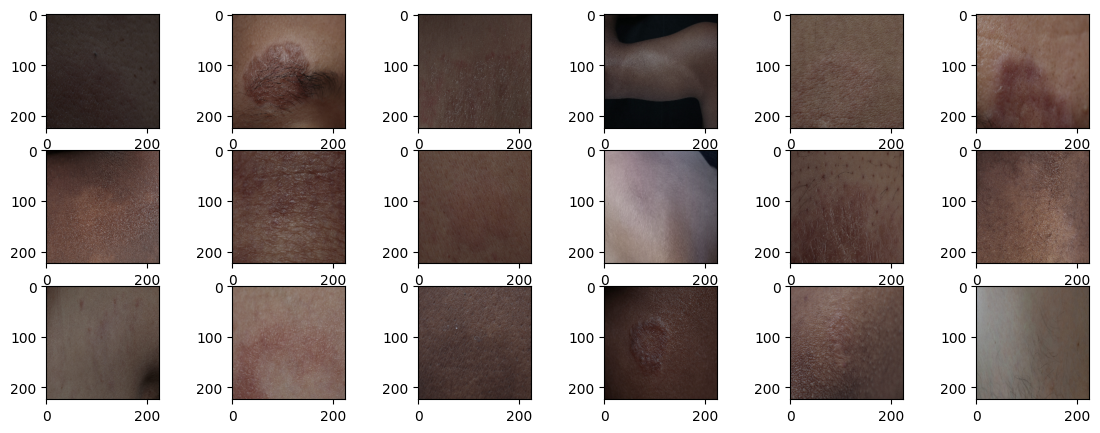

In [166]:
columns = 6
rows    = 3
fig = plt.figure(figsize=(14,5))
for i in range(len(df_performance)):
    #print(df_performance.loc[i,'filename'])
  imagem=load_img(df_performance.loc[i,'filename'], target_size=(224,224,3));
  imagem=np.array(imagem)
  cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
  df_performance.loc[i,'score'] = float(cls)

  if (float(cls) > THRESHOULD):
    df_performance.loc[i,'predict'] = 'sem'
    print(f'sem {cls}')
  else:
    df_performance.loc[i,'predict'] = 'com'
    print(f'com {cls}')
  fig.add_subplot(rows,columns,i+1)
  plt.imshow(imagem)


Acurácia:  1.0
Kappa:  1.0
F1:  1.0


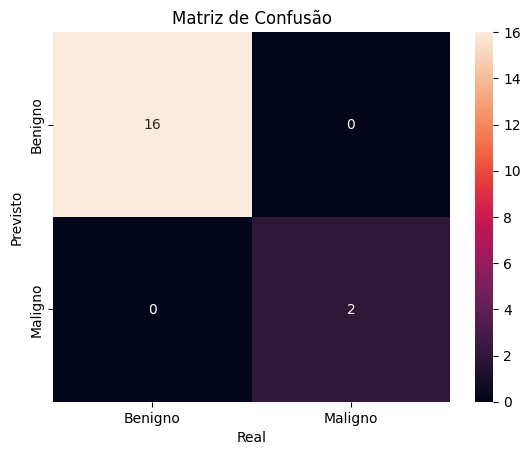

In [167]:
y_test = df_performance['class']
y_pred = df_performance['predict']
predict_and_evaluate(y_test, y_pred)